<a href="https://colab.research.google.com/github/JoshFowlkes/DS-Unit-2-Regression-Classification/blob/master/module2/assignment_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Do the [Plotly Dash](https://dash.plot.ly/) Tutorial, Parts 1 & 2.
- [ ] Add your own stretch goal(s) !

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.0.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [0]:
# Use these functions from Lecture, for later in the assignment 

%matplotlib inline
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def regression_3d(df, x, y, z, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    """
    
    # Plot data
    fig = px.scatter_3d(df, x, y, z, **kwargs)
    
    # Fit Linear Regression
    features = [x, y]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])    
    
    # Define grid of four points in the feature space
    xmin, xmax = df[x].min(), df[x].max()
    ymin, ymax = df[y].min(), df[y].max()
    coords = [[xmin, ymin], 
              [xmin, ymax], 
              [xmax, ymin], 
              [xmax, ymax]]
    
    # Make predictions for the grid
    Z = model.predict(coords).reshape((2,2), order='F')
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x=[xmin,xmax], y=[ymin,ymax], z=Z))
    
    return fig


def regression_residuals(df, feature, target, m, b):
    """
    Visualize linear regression, with residual errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    df.plot.scatter(feature, target)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    plt.plot(x, y_pred)
    
    # Plot residual errors
    for x, y1, y2 in zip(x, y, y_pred):
        plt.plot((x, x), (y1, y2), color='grey')
    
    # Print regression metrics
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)


def regression_squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)
    


# Credit: Jake VanderPlas, Python Data Science Handbook, Chapter 5.3
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         LinearRegression(**kwargs))

In [0]:
df.head()

bathrooms  bedrooms  ... wheelchair_access common_outdoor_space
0        1.5         3  ...                 0                    0
1        1.0         2  ...                 0                    0
2        1.0         1  ...                 0                    0
3        1.0         1  ...                 0                    0
4        1.0         4  ...                 0                    0

[5 rows x 34 columns]

In [0]:
# since we;re usiing april - may as the train and june as the test, checking to see if 'created'
# is in date time format
df.dtypes
# it isn't! 


bathrooms               float64
bedrooms                  int64
created                  object
description              object
display_address          object
latitude                float64
longitude               float64
price                     int64
street_address           object
interest_level           object
elevator                  int64
cats_allowed              int64
hardwood_floors           int64
dogs_allowed              int64
doorman                   int64
dishwasher                int64
no_fee                    int64
laundry_in_building       int64
fitness_center            int64
pre-war                   int64
laundry_in_unit           int64
roof_deck                 int64
outdoor_space             int64
dining_room               int64
high_speed_internet       int64
balcony                   int64
swimming_pool             int64
new_construction          int64
terrace                   int64
exclusive                 int64
loft                      int64
garden_p

In [0]:
df['date'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df['date'].describe()

count                   48817
unique                  48148
top       2016-05-14 01:11:03
freq                        3
first     2016-04-01 22:12:41
last      2016-06-29 21:41:47
Name: date, dtype: object

In [0]:
df.head()

bathrooms  bedrooms  ... common_outdoor_space                date
0        1.5         3  ...                    0 2016-06-24 07:54:24
1        1.0         2  ...                    0 2016-06-12 12:19:27
2        1.0         1  ...                    0 2016-04-17 03:26:41
3        1.0         1  ...                    0 2016-04-18 02:22:02
4        1.0         4  ...                    0 2016-04-28 01:32:41

[5 rows x 35 columns]

In [0]:
# now for a quick look at the time frame and price

px.scatter(df, x = 'date', y= 'price', title = 'NYC apartment Costs April -June 2016', trendline = 'ols')


In [0]:
# sorting values by date so that I can group them by month for train/test
df = df.sort_values(by='date')

In [0]:
df.head()

bathrooms  bedrooms  ... common_outdoor_space                date
5186        1.0         1  ...                    0 2016-04-01 22:12:41
7945        1.0         0  ...                    0 2016-04-01 22:56:00
6424        2.0         3  ...                    1 2016-04-01 22:57:15
7719        1.0         1  ...                    1 2016-04-01 23:26:07
1723        1.0         1  ...                    0 2016-04-02 00:48:13

[5 rows x 35 columns]

# Train/Test Split, April & May = Train, June = Test

In [0]:
# Train/Test Split

# importing split from sklearn
from sklearn.model_selection import train_test_split

# creating X and Y, in this case its same since its for dates 
split_features = 'date'
split_target = 'date'
X = df[split_features]
y = df[split_target]

# fitting the model, and using train_size to get the date range right 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, 
                                                    train_size = .6523066208, # caluclated based on value counts
                                                    shuffle=False ) # gets them in order they appear

In [0]:
X_test = pd.DataFrame

X_test
# checking to make sure that both ends only consist only of June 

15697   2016-05-31 23:10:48
11474   2016-06-01 01:10:37
19176   2016-06-01 01:11:06
16226   2016-06-01 01:11:12
37756   2016-06-01 01:11:52
17946   2016-06-01 01:12:22
17828   2016-06-01 01:15:13
20003   2016-06-01 01:16:07
16093   2016-06-01 01:16:37
20830   2016-06-01 01:18:49
14302   2016-06-01 01:19:02
20307   2016-06-01 01:19:05
19786   2016-06-01 01:19:07
12338   2016-06-01 01:19:23
39254   2016-06-01 01:20:09
18167   2016-06-01 01:20:13
17303   2016-06-01 01:20:17
37998   2016-06-01 01:20:25
12666   2016-06-01 01:20:43
7076    2016-06-01 01:21:35
12200   2016-06-01 01:22:14
39731   2016-06-01 01:22:15
18920   2016-06-01 01:22:55
16123   2016-06-01 01:38:13
22420   2016-06-01 01:38:19
4858    2016-06-01 01:38:41
13857   2016-06-01 01:38:53
11817   2016-06-01 01:39:24
24027   2016-06-01 01:39:44
19274   2016-06-01 01:40:21
                ...        
23666   2016-06-29 17:14:02
44582   2016-06-29 17:14:07
10898   2016-06-29 17:15:08
24148   2016-06-29 17:17:01
4958    2016-06-29 1

# Two New Features

In [0]:
df['bedrooms_bathroom'] = (df['bathrooms'] + df['bedrooms'])
df.head()

bathrooms  bedrooms  ...                date bedrooms_bathroom
5186        1.0         1  ... 2016-04-01 22:12:41               2.0
7945        1.0         0  ... 2016-04-01 22:56:00               1.0
6424        2.0         3  ... 2016-04-01 22:57:15               5.0
7719        1.0         1  ... 2016-04-01 23:26:07               2.0
1723        1.0         1  ... 2016-04-02 00:48:13               2.0

[5 rows x 36 columns]

In [0]:
df['latitude_longitude'] = list(zip(df.latitude, df.longitude))
df.head()

bathrooms  bedrooms  ... bedrooms_bathroom   latitude_longitude
5186        1.0         1  ...               2.0  (40.7302, -73.9924)
7945        1.0         0  ...               1.0  (40.7576, -73.9677)
6424        2.0         3  ...               5.0  (40.7388, -73.9851)
7719        1.0         1  ...               2.0  (40.7939, -73.9738)
1723        1.0         1  ...               2.0  (40.7784, -73.9491)

[5 rows x 37 columns]

# Linear Regression model with at least two features

In [0]:
model = LinearRegression()

features = ['latitude', 'longitude']
target = 'price'

X = df[features]
y = df[target]

model.fit(X,y)
y_pred = model.predict(X)

df['predicted'] = y_pred
df['error'] = y_pred - y

df.head()

bathrooms  bedrooms  ...    predicted        error
5186        1.0         1  ...  3852.556702   657.556702
7945        1.0         0  ...  3512.886138  1512.886138
6424        2.0         3  ...  3753.348742 -2096.651258
7719        1.0         1  ...  3698.043606   953.043606
1723        1.0         1  ...  3257.494060   857.494060

[5 rows x 39 columns]

In [0]:
# 3d regression for latitude and longitude
regression_3d(df,
             x = 'latitude',
             y = 'longitude',
             z = 'price',
             )

In [0]:
# removing the one outlier with 10 bathrooms to get a better view on 3d regression
mask = (df['bathrooms'] < 9)
df = df[mask]

In [0]:
model = LinearRegression()

features = ['bedrooms', 'bathrooms']
target = 'price'

X = df[features]
y = df[target]

model.fit(X,y)
y_pred = model.predict(X)

df['predicted2'] = y_pred
df['error2'] = y_pred - y

df.head()

bathrooms  bedrooms  ...   predicted2      error2
5186        1.0         1  ...  2947.738040 -247.261960
7945        1.0         0  ...  2567.141708  567.141708
6424        2.0         3  ...  5828.887667  -21.112333
7719        1.0         1  ...  2947.738040  202.738040
1723        1.0         1  ...  2947.738040  547.738040

[5 rows x 41 columns]

In [0]:
# 3d regression for bedrooms and bathrooms

regression_3d(df,
             x='bedrooms',
             y='bathrooms',
             z='price'
             )

# Get the model's coefficients and intercept

In [0]:
print('Intercept:', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept: 447.18474406858195
bedrooms      380.596331
bathrooms    2119.956964


In [0]:
# using the model to predict 2 bedroom to bath
model.predict([[2,2]])

array([5448.29133558])

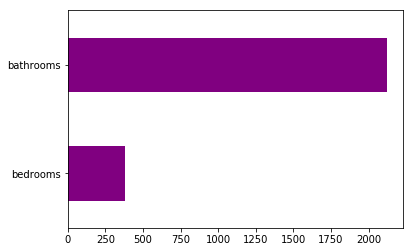

In [0]:
coefficients.sort_values().plot.barh(color='purple')

# Get Regression metrics RMSE, MAE, and R^2

In [0]:
df['error2'].abs().mean()

# so the Mean absolute error(MAE) for bedrooms and baths has an average error of 821 dollars 

821.9040402935649

In [0]:

rmse = np.std(df['error2'])
rmse
# the Root mean square error( standard dev of prediction errors) is 1224 dollars wow

1224.7894738801474

In [0]:
df['error'].abs().mean()
# the MAE for latitude and longitude was 1146 dollars oh my 

1146.5565400998419

In [0]:
# also could have done
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y, y_pred)

821.9040402936165

# Trying for an even more accurate set of features

In [0]:
model = LinearRegression()

features = ['bedrooms_bathroom', 'longitude']
target = 'price'

X = df[features]
y = df[target]

model.fit(X,y)
y_pred = model.predict(X)

df['predicted3'] = y_pred
df['error3'] = y_pred - y

df.head()

bathrooms  bedrooms  ...   predicted3      error3
5186        1.0         1  ...  3300.507264  105.507264
7945        1.0         0  ...  2061.743020   61.743020
6424        2.0         3  ...  5650.237801 -199.762199
7719        1.0         1  ...  2988.246123  243.246123
1723        1.0         1  ...  2573.576759  173.576759

[5 rows x 43 columns]

In [0]:
# now to check MAE 
mean_absolute_error(y, y_pred)

# nice, so a bit lower, will try for lower

810.4922908486628

In [0]:
model = LinearRegression()

features = ['bedrooms_bathroom', 'longitude']
target = 'price'

X = df[features]
y = df[target]

model.fit(X,y)
y_pred = model.predict(X)

df['predicted4'] = y_pred
df['error4'] = y_pred - y

df.head()

bathrooms  bedrooms  ...   predicted4      error4
5186        1.0         1  ...  3300.507264  105.507264
7945        1.0         0  ...  2061.743020   61.743020
6424        2.0         3  ...  5650.237801 -199.762199
7719        1.0         1  ...  2988.246123  243.246123
1723        1.0         1  ...  2573.576759  173.576759

[5 rows x 45 columns]

# Organize and Comment Code


In [0]:


# converting from string to datetime
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)

# sorting values based on date so that I can get appropraite train/target time frames
df = df.sort_values(by='created')
   

####### Train/Test Split#####
# importing split from sklearn
from sklearn.model_selection import train_test_split

# creating X and Y, in this case its same since its for dates 
split_features = ['bedrooms', 'price']
split_target = 'created'
X = df[split_features]
y = df[split_target]

# fitting the model, and using train_size to get the date range right 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, 
                                                    train_size = .6523066208, # caluclated based on value counts
                                                    shuffle=False ) # gets them in order they appear

###########

# fixing the number of bathrooms
mask = (df['bathrooms'] < 9)
df = df[mask]

# Linear Regression 
from sklearn.linear_model import LinearRegression
model = LinearRegression()

features = ['bedrooms', 'bathrooms']
target = 'price'

X = df[features]
y = df[target]

model.fit(X,y)
y_pred = model.predict(X)

df['predicted'] = y_pred
df['error'] = y_pred - y




In [0]:

regression_3d(df,
             x='bedrooms',
             y='bathrooms',
             z='price'
             )

In [0]:
# coefficients for Linear Regression
print('Intercept:', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept: 447.18474406858195
bedrooms      380.596331
bathrooms    2119.956964


In [0]:
# mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y, y_pred)

821.9040402936165

In [0]:
# root mean square error

rmse = np.std(df['error'])
rmse

1224.7894738801474

In [0]:
# R^2
from sklearn.metrics import r2_score
r2_score(y, y_pred)

0.5170537949865899

In [0]:
# Train Linear Regression model on 2 features
# total_rooms and pets_allowed

from sklearn.linear_model import LinearRegression

# Instantiate the model
two_feat = LinearRegression()

# Create X matrix and y intercept
features = ['total_rooms', 'pets_allowed']
target = 'price'

# Fit the model
two_feat.fit(train_mask[features], train_mask[target])

In [0]:
# Calculate metrics for train/test
def metrics():
  
  # Calculate metrics on training data
  y_true = train_mask[target]
  y_pred = two_feat.predict(train_mask[features])
  train_error = mean_absolute_error(y_true, y_pred)
  train_r2 = r2_score(y_true, y_pred)
  train_rmse = np.sqrt(mean_squared_error(y_true, y_pred))


  # Calculate metrics on the test data
  y_true = test_mask[target]
  y_pred = two_feat.predict(test_mask[features])
  test_error = mean_absolute_error(y_true, y_pred)
  test_r2 = r2_score(y_true, y_pred)
  test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  
  # Get model coefficients and intercepts
  intercept = two_feat.intercept_
  coefficients = pd.Series(two_feat.coef_, features)


  # Display the errors
  print('------------------Linear Regression Model Results------------------')
  print('Training Data')
  print('Train MAE: $', round(train_error))
  print('Train R^2:', round(train_r2))
  print('Train RMSE:', round(train_rmse), '\n')
  print('Test Data')
  print('Test Error: $', round(test_error))
  print('Test R^2:', round(test_r2))
  print('Test RMSE:', round(test_rmse), '\n')
  print('Intercept and Coefficients:')
  print('Intercept:', two_feat.intercept_)
  print(coefficients.to_string())